### Fix: Winsorizing Monthly Returns

When we build portfolios month by month, the **average return** for a month can be **badly distorted by extreme outliers** — for example:
- A bankrupt company suddenly dropping –90%
- A penny stock jumping +800%  
- A merger deal causing one stock to spike +300%

Even though we filtered for common stocks, **huge outlier returns still happen**, and they create **crazy noise** in the long-short return every month.

**Winsorization** solves this by **capping** extreme returns:
- For example, we could clip any stock return above **+100%** to **+100%**, and any return below **–100%** to **–100%**.
- (Or even more conservatively, clip at ±50% returns.)

This protects our monthly long-short return from being dominated by 1 or 2 crazy events.



Data prep:

In [14]:
import pandas as pd
df = pd.read_csv("../data/processed/full_similarity_with_returns.csv")

df = df.rename(columns={"filing_date": "month", "similarity": "similarity_score"})

df = df.dropna(subset=['similarity_score', 'tic', 'ret'])

df['month'] = pd.to_datetime(df['month'])

df

,cik,tic,month,similarity_score,ret
2,1750,air,1994-08-31,0.934598,-2.7027
3,1750,air,1994-10-31,0.928699,-4.8462
4,1750,air,1995-01-31,0.868299,1.8318
6,1800,abt,1994-05-31,0.934639,5.2863
7,1800,abt,1994-08-31,0.888515,6.6667
...,...,...,...,...,...
1299053,85535,rgld,2024-12-31,0.923907,-9.8523
1300115,1058811,immr,2024-12-31,0.985401,-2.3490
1300909,1393612,dfs,2024-12-31,0.977140,-5.0430
1300910,1393612,dfs,2024-12-31,0.998017,-5.0430


Stocks per month filter:

In [15]:
min_stocks_per_month = 100

month_counts = df['month'].value_counts()
valid_months = month_counts[month_counts >= min_stocks_per_month].index
df = df[df['month'].isin(valid_months)].copy()

print(f"after filtering, dataframe shape: {df.shape}")


after filtering, dataframe shape: (27662, 5)


In [16]:
month_sizes = df['month'].value_counts().sort_index()
print(month_sizes)

month
1994-05-31    310
1994-08-31    314
1994-11-30    328
1995-05-31    436
1995-06-30    107
             ... 
2024-02-29    499
2024-04-30    246
2024-05-31    837
2024-09-30    116
2024-10-31    583
Name: count, Length: 95, dtype: int64


### Winsorizing:

In [17]:

def winsorize_returns(group):
    lower = group['ret'].quantile(0.25)
    upper = group['ret'].quantile(0.995)
    group['ret'] = group['ret'].clip(lower, upper)
    return group

df = df.groupby('month', group_keys=False).apply(winsorize_returns)

print("Winsorization complete.")


Winsorization complete.


/var/folders/nx/v58k3cwd0wlgff1pwy874p600000gn/T/ipykernel_34276/1484663254.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('month', group_keys=False).apply(winsorize_returns)


Hard-cap returns didn't work well

Quintiles

In [18]:
def custom_assign_quintile(group):
    group = group.sort_values('similarity_score', ascending=False).reset_index(drop=True)
    
    if len(group) == 2:
        group['quintile'] = [5, 1]  # Long top, short bottom
    else:
        group['quintile'] = pd.qcut(group.index, 5, labels=[5,4,3,2,1]).astype(int)
    
    return group

df = df.groupby('month', group_keys=False).apply(custom_assign_quintile)

print("Quintiles assigned.")


Quintiles assigned.


/var/folders/nx/v58k3cwd0wlgff1pwy874p600000gn/T/ipykernel_34276/1629635580.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('month', group_keys=False).apply(custom_assign_quintile)


In [19]:
df

,cik,tic,month,similarity_score,ret,quintile
0,77543,tpc,1994-05-31,0.999931,-1.03090,5
1,77543,tpc,1994-05-31,0.999931,-3.43125,5
2,66740,mmm,1994-05-31,0.997694,4.97960,5
3,96021,syy,1994-05-31,0.997097,-0.48080,5
4,795403,wts,1994-05-31,0.996169,-1.89360,5
...,...,...,...,...,...,...
578,310764,syk,2024-10-31,0.811373,-1.37850,1
579,1060822,cri,2024-10-31,0.809041,-7.80470,1
580,1103982,mdlz,2024-10-31,0.808797,-7.04490,1
581,85961,r,2024-10-31,0.794451,0.32920,1


Making Portfolios

In [20]:

portfolio_rets = []

for month, group in df.groupby('month'):
    long_ret = group.loc[group['quintile'] == 5, 'ret'].mean()
    short_ret = group.loc[group['quintile'] == 1, 'ret'].mean()
    long_short = long_ret - short_ret
    portfolio_rets.append({'month': month, 'portfolio_return': long_short})

portfolio_df = pd.DataFrame(portfolio_rets)
portfolio_df = portfolio_df.sort_values('month')

print("Monthly portfolio returns computed.")


Monthly portfolio returns computed.


In [21]:
portfolio_df

,month,portfolio_return
0,1994-05-31,-0.051703
1,1994-08-31,-0.501820
2,1994-11-30,-1.068947
3,1995-05-31,-0.659955
4,1995-06-30,0.801118
...,...,...
90,2024-02-29,1.781186
91,2024-04-30,-0.076531
92,2024-05-31,-2.296654
93,2024-09-30,-0.394045


Plot

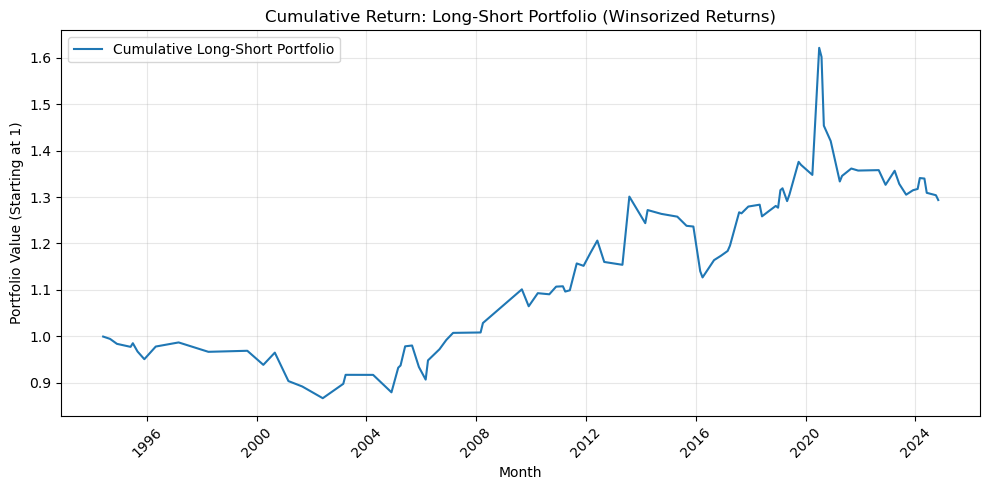

In [22]:
import matplotlib.pyplot as plt


portfolio_df['portfolio_return_decimal'] = portfolio_df['portfolio_return'] / 100
portfolio_df['cum_portfolio'] = (1 + portfolio_df['portfolio_return_decimal']).cumprod()

# Plot
plt.figure(figsize=(10,5))
plt.plot(portfolio_df['month'], portfolio_df['cum_portfolio'], label='Cumulative Long-Short Portfolio')
plt.xlabel('Month')
plt.ylabel('Portfolio Value (Starting at 1)')
plt.title('Cumulative Return: Long-Short Portfolio (Winsorized Returns)')
plt.legend()
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [23]:
import numpy as np

# Load your portfolio returns if not already loaded
# portfolio_df = pd.read_csv('../data/processed/full_portfolio_returns_filtered.csv')

# 1. Calculate average monthly long-short return
mean_return = portfolio_df['portfolio_return_decimal'].mean()

# 2. Calculate standard deviation of monthly returns
std_dev = portfolio_df['portfolio_return_decimal'].std()

# 3. Calculate Sharpe ratio (annualized)
sharpe_ratio = (mean_return/ std_dev) * np.sqrt(12)  # 12 months per year

# 4. Print results
print(f"Average Monthly Return: {mean_return*100:.4f}%")
print(f"Monthly Return Std Dev: {std_dev*100:.4f}%")
print(f"Annualized Sharpe Ratio: {sharpe_ratio:.4f}")


Average Monthly Return: 0.3364%
Monthly Return Std Dev: 3.7001%
Annualized Sharpe Ratio: 0.3149


This is slightly avg return (regular 0.05%) and slightly better volatility (vs 4.6%)

Techically, the hypothesis is confirmed, there are positive average return when we invest in lazy prices, and that is even the case with extreme outliers,, fake stocks, not accounting for dividends, M&A's, and all that stuff that hapens to stocks. many stocks that could have matched with WRDS' permno id are not easily found right now at SEC's websites, and that would have been an extremely hard map to build for us. So a lot of positive alpha was lost when we left those uot during merging stock returns. 

So:
- returns are crazy
- stocks are lost in translation

Still positive (a little)

This is uncomparable to SP500. SP500 is an living-breathing index that drops dead stocks and !!! weighs stocks by market cap. We don't have this ability. So of course, the index will outperform us. However

### What if we imagine that we are Warrent Buffet (TM) and cherry-pick stocks. Who will win then??

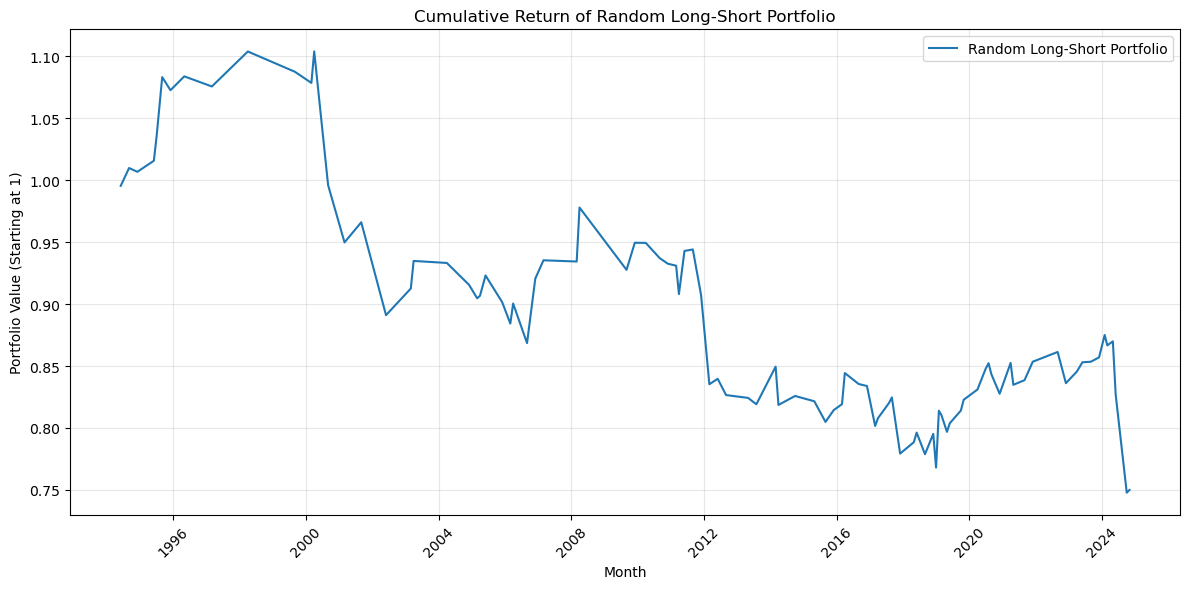

Average Monthly Return (Random Portfolio): -0.2606%
Monthly Return Std Dev (Random Portfolio): 2.8743%
Annualized Sharpe Ratio (Random Portfolio): -0.3140


In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assume df is already loaded and cleaned (no missing 'ret', no small months)

# Group by month and randomly assign 20% long and 20% short
random_portfolio_rets = []

for month, group in df.groupby('month'):
    group = group.sample(frac=1)  # Shuffle to randomize

    n = len(group)
    n_20 = n // 5  # 20%

    long_group = group.iloc[:n_20]
    short_group = group.iloc[-n_20:]

    long_ret = long_group['ret'].mean()
    short_ret = short_group['ret'].mean()

    long_short_return = long_ret - short_ret

    random_portfolio_rets.append({'month': month, 'random_long_short_return': long_short_return})

# Convert to DataFrame
random_portfolio_df = pd.DataFrame(random_portfolio_rets)

# Sort by month
random_portfolio_df = random_portfolio_df.sort_values('month')

# Compute cumulative return
random_portfolio_df['random_return_decimal'] = random_portfolio_df['random_long_short_return'] / 100
random_portfolio_df['cum_random_portfolio'] = (1 + random_portfolio_df['random_return_decimal']).cumprod()

# Plot
plt.figure(figsize=(12,6))
plt.plot(random_portfolio_df['month'], random_portfolio_df['cum_random_portfolio'], label='Random Long-Short Portfolio')
plt.xlabel('Month')
plt.ylabel('Portfolio Value (Starting at 1)')
plt.title('Cumulative Return of Random Long-Short Portfolio')
plt.legend()
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Performance Metrics for Random Portfolio

mean_monthly_return = random_portfolio_df['random_long_short_return'].mean()
std_monthly_return = random_portfolio_df['random_long_short_return'].std()

# Sharpe ratio (annualized, assume 12 months)
sharpe_ratio = (mean_monthly_return / std_monthly_return) * np.sqrt(12)

print(f"Average Monthly Return (Random Portfolio): {mean_monthly_return:.4f}%")
print(f"Monthly Return Std Dev (Random Portfolio): {std_monthly_return:.4f}%")
print(f"Annualized Sharpe Ratio (Random Portfolio): {sharpe_ratio:.4f}")



Pick any random portfolio, it rarely outperforms. This is our simulated day trading!

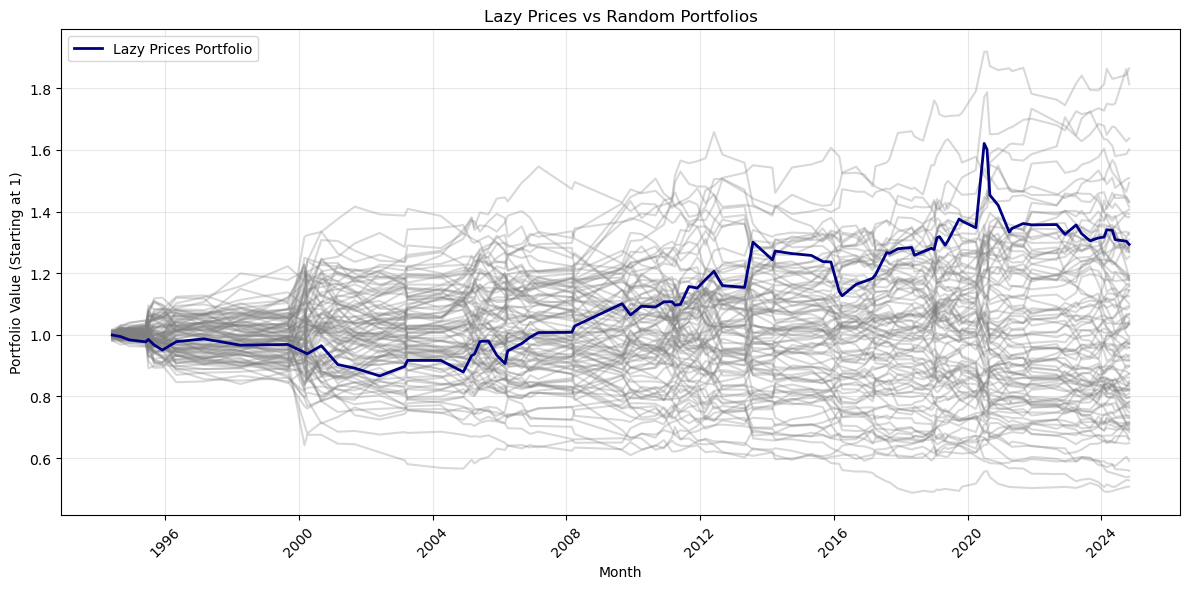

In [67]:
import numpy as np
import matplotlib.pyplot as plt

n_simulations = 100  # Number of random portfolios to generate

# Prepare plot
plt.figure(figsize=(12,6))

# Loop over simulations
for sim in range(n_simulations):
    random_rets = []

    for month, group in df.groupby('month'):
        if len(group) >= 5:
            n_long = len(group) // 5
            n_short = len(group) // 5

            random_long = group.sample(n=n_long, replace=False)
            random_short = group.drop(random_long.index).sample(n=n_short, replace=False)

            long_ret = random_long['ret'].mean()
            short_ret = random_short['ret'].mean()

            long_short_ret = long_ret - short_ret
            random_rets.append({'month': month, 'random_return': long_short_ret})

    random_df = pd.DataFrame(random_rets).sort_values('month')
    random_df['random_return_decimal'] = random_df['random_return'] / 100
    random_df['cum_random'] = (1 + random_df['random_return_decimal']).cumprod()

    # Plot each random cumulative return in light gray
    plt.plot(random_df['month'], random_df['cum_random'], color='gray', alpha=0.3)

# Now overlay your Lazy Prices portfolio
plt.plot(portfolio_df['month'], portfolio_df['cum_portfolio'], color='navy', label='Lazy Prices Portfolio', linewidth=2)

plt.xlabel('Month')
plt.ylabel('Portfolio Value (Starting at 1)')
plt.title('Lazy Prices vs Random Portfolios')
plt.legend()
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**Random Portfolio Simulation**

We plotted the cumulative returns of 100 randomly generated long-short portfolios alongside the cumulative return of our Lazy Prices portfolio. 

Each random portfolio, shown in light gray, was constructed by randomly selecting 20% of stocks to go long and 20% to go short each month (matching our quintile strategy setup).  
The Lazy Prices strategy is highlighted in dark blue.

The cloud of random portfolios exhibits behavior similar to **Brownian motion**, meaning:
- There is wide dispersion in outcomes over time.
- Most random portfolios tend to hover around their starting value (portfolio value near 1).
- A few random portfolios by chance perform very well (drifting upward), and a few collapse (drifting downward).
- Overall, randomness introduces **both positive and negative drifts**, but no systematic edge.

Compared to this random distribution, the Lazy Prices portfolio shows a **mild but steady upward drift** after about 2004–2005, suggesting that the similarity score signal may carry **some predictive power** relative to pure chance.

However, the performance difference is **not dramatic** — Lazy Prices does **outperform many** random portfolios, but **is also outperformed by some** random outcomes. What it does well is avoid collapsing due to randomness, and giving you a certain positive return outcome.